In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

from util.collision_loss import collision_check, collision_loss
from util.zonotope import Zonotope
from util.constrained_zonotope import ConstrainedZonotope
from util.NN_con_zono import forward_pass_NN_con_zono

# Feedforward network

In [67]:
# 3 Layer ReLU Feedforward Network
# 2 - 100 - 100 - 2

n_L1 = 10
n_L2 = 10

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, n_L2)  
        self.fc2 = nn.Linear(n_L1, n_L2)
        self.fc3 = nn.Linear(n_L2, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Use nonlinear function to generate data

In [73]:
# nonlinear function (vectorized)
def f_nonl(x):
    return np.array([x[:,0]**2 + np.sin(x[:,1]),
                     x[:,1]**2 + np.sin(x[:,0])])

# training set
N_train = 10000
X_train = np.random.uniform(-1, 1, (N_train,2))

# compute y's
Y_train = f_nonl(X_train)

X_train = torch.as_tensor(X_train, dtype=torch.float)
Y_train = torch.as_tensor(Y_train.T, dtype=torch.float)

In [75]:
# test set
N_test = 10000
X_test = np.random.uniform(-1, 1, (N_test,2))

# compute y's
Y_test = f_nonl(X_test)

X_test = torch.as_tensor(X_test, dtype=torch.float)
Y_test = torch.as_tensor(Y_test.T, dtype=torch.float)

In [76]:
# train the network
optimizer = optim.SGD(net.parameters(), lr=0.1)

loss = nn.MSELoss()

num_iters = 1000

# training loop:
for i in range(num_iters):
    optimizer.zero_grad()   # zero the gradient buffers

    pred = net(X)

    output = loss(pred, Y)
    #print('loss: ', output)
    output.backward()
    optimizer.step() 

Text(0.5, 1.0, 'Y test pred')

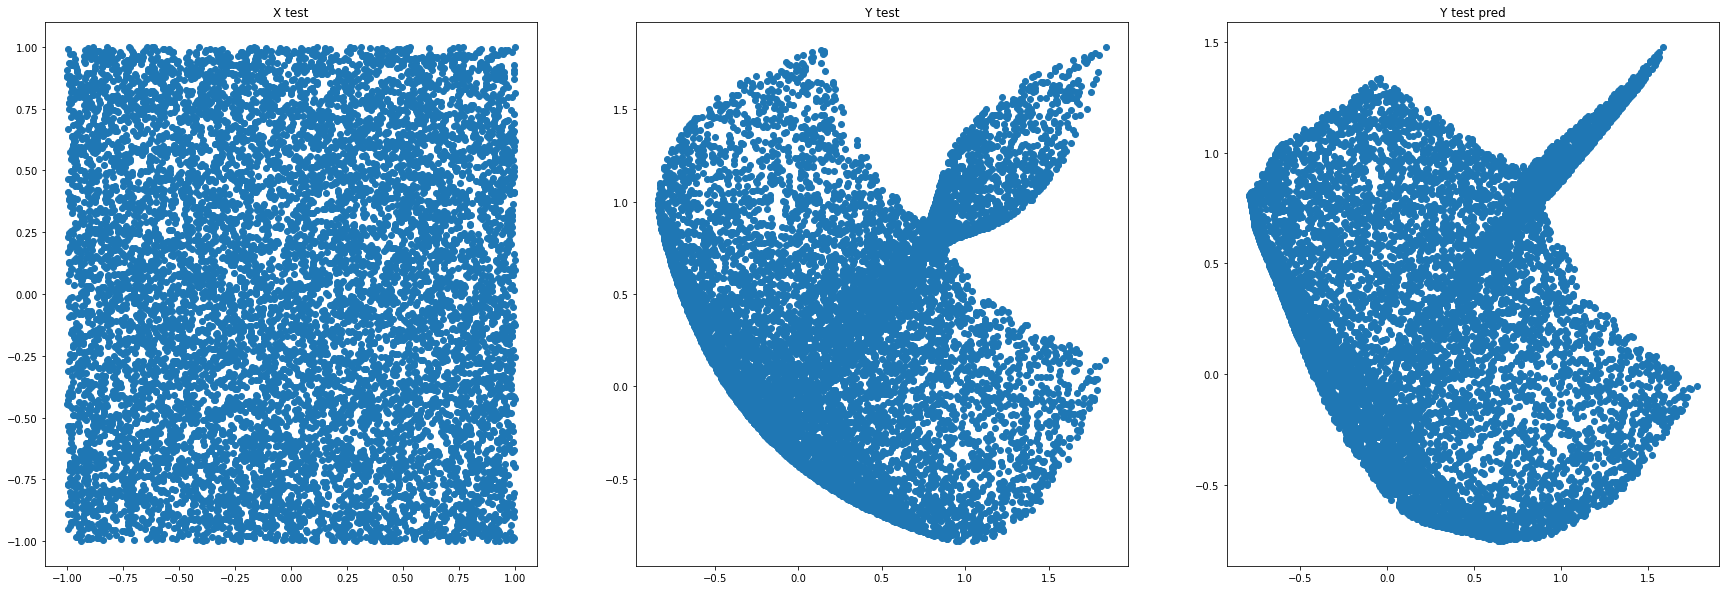

In [77]:
Y_test_pred = net(X_test)
test_loss = loss(Y_test_pred, Y_test)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.scatter(X_test[:,0], X_test[:,1]); ax1.set_title('X test')
ax2.scatter(Y_test[:,0], Y_test[:,1]); ax2.set_title('Y test')
ax3.scatter(Y_test_pred[:,0].detach().numpy(), Y_test_pred[:,1].detach().numpy()); ax3.set_title('Y test pred')

In [78]:
for param in net.parameters():
  print(param)

Parameter containing:
tensor([[ 0.1807,  0.4910],
        [-0.1220, -0.1153],
        [ 0.6735, -0.4029],
        [-0.1839,  0.7109],
        [-1.1726,  0.5121],
        [ 0.7576,  0.3558],
        [-0.2134, -0.8211],
        [ 0.8975,  0.5858],
        [ 0.1736,  0.0162],
        [ 0.4813,  0.5723]], requires_grad=True)
Parameter containing:
tensor([ 0.7226, -0.6544,  0.3148, -0.4390,  0.4589,  0.3335,  0.7413,  0.5439,
        -0.4042, -0.3152], requires_grad=True)
Parameter containing:
tensor([[ 0.2303,  0.0168, -0.1487,  0.3345, -0.1734,  0.0929,  0.2269,  0.2362,
          0.0805,  0.0227],
        [ 0.3291, -0.2349, -0.1503, -0.2443,  0.5621, -0.3531,  0.2365, -0.3040,
          0.1227, -0.2322],
        [ 0.2112,  0.1060,  0.4936,  0.2549,  0.1273,  0.2057, -0.3863,  0.4325,
          0.1322,  0.3827],
        [ 0.1934, -0.0587,  0.1834, -0.2546, -0.4355,  0.0720,  0.0752,  0.4287,
         -0.1822, -0.2055],
        [ 0.2121,  0.0941, -0.1277, -0.1562,  0.4598,  0.4044, -0.0897

# Neural network reachability

In [85]:
# extract weights and biases from network
NN_weights = []
NN_biases = []

idx = 0
for param in net.parameters():
    if idx % 2 == 0: # "even" parameters are weights
        NN_weights.append(param.data.numpy())
    else: # "odd" parameters are weights
        NN_biases.append(param.data.numpy())
    idx += 1

# input zonotope
Z_in = Zonotope(np.zeros((2,1)),np.eye(2))

forward_pass_NN_con_zono(Z_in, NN_weights, NN_biases)

ValueError: operands could not be broadcast together with shapes (2,10) (2,) 

In [87]:
NN_weights

[array([[ 0.18074706,  0.49099615],
        [-0.12199575, -0.1153276 ],
        [ 0.67349994, -0.4029472 ],
        [-0.18391696,  0.7109318 ],
        [-1.1725638 ,  0.5121456 ],
        [ 0.7575828 ,  0.3558449 ],
        [-0.21340047, -0.8210664 ],
        [ 0.8974507 ,  0.58579177],
        [ 0.17360026,  0.01615524],
        [ 0.481271  ,  0.5723342 ]], dtype=float32),
 array([[ 0.23028184,  0.01681098, -0.14866817,  0.33453304, -0.17340337,
          0.09287342,  0.22693683,  0.23617564,  0.08049637,  0.02272764],
        [ 0.32906377, -0.23494197, -0.15033083, -0.24425861,  0.5621267 ,
         -0.3530637 ,  0.23649955, -0.30399385,  0.12268898, -0.23215057],
        [ 0.2112167 ,  0.10601869,  0.49361902,  0.2549274 ,  0.127286  ,
          0.20566389, -0.38629222,  0.432482  ,  0.13224804,  0.3826586 ],
        [ 0.19340989, -0.05865777,  0.18339422, -0.25459784, -0.43551722,
          0.0719574 ,  0.07515889,  0.42874774, -0.18221895, -0.20553744],
        [ 0.21208133,  0.09

# Constrained training

In [ ]:
# constraint function 
# for now, something simple: constrain weights to be positive

def constraint(net):
    


In [ ]:
# train the network
optimizer = optim.SGD(net.parameters(), lr=0.1)

loss = nn.MSELoss()

num_iters = 1000

# training loop:
for i in range(num_iters):
    optimizer.zero_grad()   # zero the gradient buffers

    pred = net(X)

    output = loss(pred, Y)
    #print('loss: ', output)
    output.backward()
    optimizer.step() 